In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

sns.set()

plt.rcParams['axes.facecolor']='#fafafa'
plt.rcParams['savefig.facecolor']='#fafafa'

## Load data

Downloaded from IMDB at https://www.imdb.com/interfaces/

In [ ]:
df_movies = pd.read_csv('../data/title.basics.tsv', sep='\t')
df_ratings = pd.read_csv('../data/title.ratings.tsv', sep='\t')

df_movies.head()

In [50]:
# use np.nan instead of string fill value
df_movies = df_movies.replace('\\N',np.NaN)

# Filter out non-movies and porn movies
df_movies = df_movies.query('(titleType == "movie") and (isAdult ==0)')

# preprocess columns
df_movies = df_movies.drop(['titleType', 'isAdult', 'endYear'], axis=1)
df_movies.columns = ['movie_id', 'primary_title', 'original_title', 'release_year', 'duration', 'genres']

df_movies.head(3)

,movie_id,primary_title,original_title,release_year,duration,genres
498,tt0000502,Bohemios,Bohemios,1905,100,NaN
570,tt0000574,The Story of the Kelly Gang,The Story of the Kelly Gang,1906,70,"Action,Adventure,Biography"
587,tt0000591,The Prodigal Son,L'enfant prodigue,1907,90,Drama


In [51]:
# preprocess year
df_movies = df_movies[df_movies.release_year.notnull()]
df_movies.release_year = df_movies.release_year.astype(int)
df_movies = df_movies.query('release_year >= 1960')
print(f'Dataset contains {df_movies.shape[0]:,} movies released since 1960')

# remove movies that were not released yet
df_movies = df_movies[df_movies.release_year < 2022]

Dataset contains 418,621 movies released since 1960


In [52]:
# extract romance genre
print(f'{round(df_movies.genres.isnull().sum() / df_movies.shape[0] * 100,2)}% have no genre information.')
df_movies = df_movies[df_movies.genres.notnull()]
df_movies['is_romance'] = df_movies.genres.str.lower().str.contains('romance')

pct_romance = df_movies.is_romance.sum() / df_movies.shape[0] * 100
print(f'{round(pct_romance,2)}% of movies have romantic plot.')

10.35% have no genre information.
8.48% of movies have romantic plot.


Text(0.5, 1.0, 'How Many Movies Were Released This Year?')

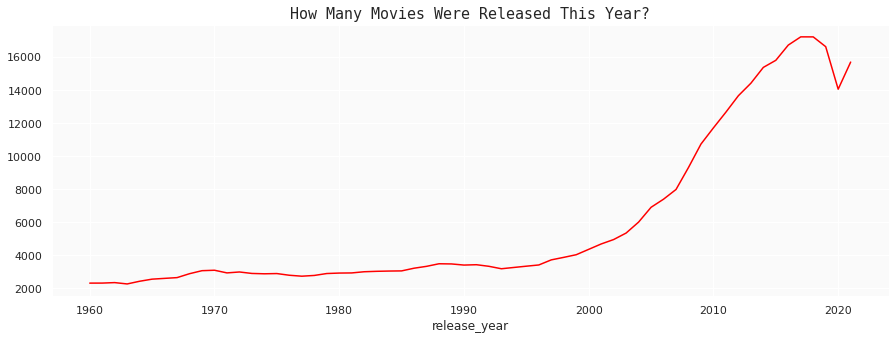

In [53]:
plt.figure(figsize=(15,5))
df_movies.groupby('release_year').count().primary_title.plot(color='red')
plt.title('How Many Movies Were Released This Year?', fontsize=15, fontfamily='monospace')

Text(0.5, 1.0, 'Proportion of Romantic Movies By Year')

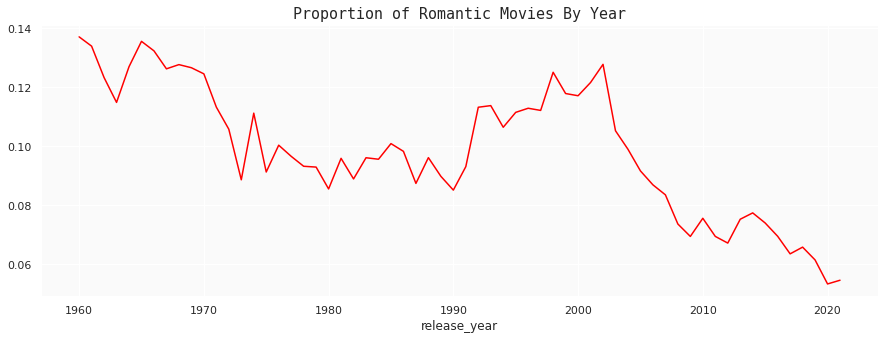

In [54]:
plt.figure(figsize=(15,5))
df_movies.groupby('release_year').apply(lambda year: year.is_romance.sum() / year.shape[0]).plot(color='red')
plt.title('Proportion of Romantic Movies By Year', fontsize=15, fontfamily='monospace')

## Add Ratings

In [74]:
df_romances = df_movies.query('is_romance')

In [57]:
df_ratings.columns = ['movie_id', 'rating', 'num_votes']

In [76]:
df = df_romances.merge(df_ratings, on='movie_id', how='left')
df.head(3)

,movie_id,primary_title,original_title,release_year,duration,genres,is_romance,rating,num_votes
0,tt0015724,Dama de noche,Dama de noche,1993,102,"Drama,Mystery,Romance",True,6.2,25.0
1,tt0035423,Kate & Leopold,Kate & Leopold,2001,118,"Comedy,Fantasy,Romance",True,6.4,82463.0
2,tt0047027,La gitana y el charro,La gitana y el charro,1964,87,"Comedy,Musical,Romance",True,4.8,15.0


In [77]:
num_no_votes = df[df.num_votes.isnull()].shape[0] / df.shape[0] * 100
print(f'{round(num_no_votes,2)}% of movies have no votes on IMDB.')

df = df[df.num_votes.notnull()]
df.shape[0]

23.19% of movies have no votes on IMDB.


24022

/home/jumbo/.cache/pypoetry/virtualenvs/mars-venus-dxxCsHEx-py3.9/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='num_votes'>

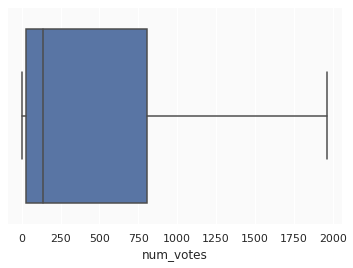

In [78]:
sns.boxplot(df.num_votes, showfliers=False)

In [98]:
TOP_YEAR = 20
data = df.groupby('release_year').apply(lambda y: y.sort_values(by='num_votes', ascending=False).iloc[:TOP_YEAR])\
    .set_index('movie_id').sort_values(by='release_year', ascending=False)
data.head()

,primary_title,original_title,release_year,duration,genres,is_romance,rating,num_votes
movie_id,,,,,,,,
tt8231668,Good on Paper,Good on Paper,2021,92,"Comedy,Romance",True,5.6,10616.0
tt9766332,Atrangi Re,Atrangi Re,2021,138,"Comedy,Drama,Romance",True,6.8,17609.0
tt10293406,The Power of the Dog,The Power of the Dog,2021,126,"Drama,Romance,Western",True,7.0,68137.0
tt8847712,The French Dispatch,The French Dispatch,2021,107,"Comedy,Drama,Romance",True,7.4,62148.0
tt10752004,Love Hard,Love Hard,2021,104,"Comedy,Romance",True,6.3,44469.0


## Add Actors and Age

In [99]:
data['actress'] = np.nan
data['actress_age'] = np.nan

data['actor'] = np.nan
data['actor_age'] = np.nan

data['age_gap'] = np.nan

data.head(1)

,primary_title,original_title,release_year,duration,genres,is_romance,rating,num_votes,actress,actress_age,actor,actor_age,age_gap
movie_id,,,,,,,,,,,,,
tt8231668,Good on Paper,Good on Paper,2021,92,"Comedy,Romance",True,5.6,10616.0,NaN,NaN,NaN,NaN,NaN


In [101]:
data[data.genres.str.contains('Comedy')].shape[0] / data.shape[0]

0.535483870967742

In [ ]:
df_crew = pd.read_csv('../data/title.principals.tsv', sep='\t')

In [ ]:
df_crew

In [ ]:
# get names of actors playing romantic couple
# get actors' birth year
# get actors age when movie was released (release year - birth year)
# get age gap